In [1]:
import sys
sys.path.append("/home/jaxmao/jaxmaov2_/JaxMao/")

In [2]:
%load_ext autoreload
%autoreload 2

from sklearn.datasets import load_digits
from torch.utils.data import DataLoader, Dataset
from jaxmao.modules import Module, Conv2d, Conv2dTransposed, Bind
import jaxmao.initializers as init
from jaxmao import losses, optimizers
import jax
from jaxmao import regularizers 
from sklearn.metrics import accuracy_score

In [136]:
def get_dataloader(batch_size, shuffle):
    class DigitsDataset(Dataset):
        def __init__(self, data, labels):
            self.data = data
            self.labels = labels
            
        def __len__(self):
            return len(self.data)
    
        def __getitem__(self, idx):
            return self.data[idx].reshape(-1, 8, 8, 1) / 16.0, self.labels[idx]
        
    digits = load_digits()
    data = digits.data
    targets = digits.target
    
    dataset = DigitsDataset(data, targets)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

class Autoencoder(Module):
    def __init__(self):
        super().__init__()
        self.conv1 = Conv2d(1, 128, (3,3), (2, 2), kernel_init=init.GlorotUniform())
        self.conv2 = Conv2d(128, 256, (3,3), (2, 2), kernel_init=init.GlorotUniform())
        self.conv3 = Conv2d(256, 128, (3,3), (2, 2), kernel_init=init.GlorotUniform())

        self.conv_t4 = Conv2dTransposed(128, 256, (3, 3), (2, 2), kernel_init=init.GlorotUniform())
        self.conv_t5 = Conv2dTransposed(256, 128, (3, 3), (2, 2), kernel_init=init.GlorotUniform())
        self.conv_t6 = Conv2dTransposed(128, 64, (3, 3), (2, 2), kernel_init=init.GlorotUniform())
        self.conv_out = Conv2d(64, 1, (1, 1), kernel_init=init.GlorotUniform())
        
    def call(self, x):
        return self.decoder(self.encoder(x))
    
    def encoder(self, x):
        x = jax.nn.relu(self.conv1(x))
        x = jax.nn.relu(self.conv2(x))
        x = jax.nn.relu(self.conv3(x))
        return x
        
    def decoder(self, x):
        x = jax.nn.relu(self.conv_t4(x))
        x = jax.nn.relu(self.conv_t5(x))
        x = jax.nn.relu(self.conv_t6(x))
        return jax.nn.sigmoid(self.conv_out(x))

In [137]:
seed = 425
key = jax.random.key(seed=seed)
datalodaer = get_dataloader(batch_size=32, shuffle=True)
model = Autoencoder()
params, states = model.init(key)
optimizer = optimizers.Adam(params=params, lr=0.01)
loss_fn = losses.BinaryCrossEntropy()

In [138]:
@jax.jit
def train_step(images, params, states, optimizer_states):
    def loss(images, params, states):
        predictions, states, reg = model.apply(images, params, states)
        return loss_fn(predictions, images) + reg, states

    (loss_value, states), gradients = jax.value_and_grad(loss, argnums=1, has_aux=True)(images, params, states)
    params, optimizer_states = optimizer.step(params, gradients, optimizer_states)
    return loss_value, params, states, optimizer_states

for epoch in range(50):
    losses_value = 0
    for i, (images, _) in enumerate(datalodaer):
        images = jax.device_put(images.numpy().reshape(-1, 8, 8, 1))
        loss_value, params, states, optimizer.states = train_step(images, params, states, optimizer.states)
        losses_value += loss_value
    print('losses_avg: ', losses_value / len(datalodaer))

losses_avg:  30.264402
losses_avg:  27.252264
losses_avg:  26.699083
losses_avg:  23.204845
losses_avg:  19.62805
losses_avg:  18.2372
losses_avg:  17.53718
losses_avg:  17.166374
losses_avg:  16.743332
losses_avg:  16.520514
losses_avg:  16.23135
losses_avg:  16.149355
losses_avg:  15.876467
losses_avg:  15.759433
losses_avg:  15.640991
losses_avg:  15.559472
losses_avg:  15.553541
losses_avg:  15.512536
losses_avg:  15.3774
losses_avg:  15.292154
losses_avg:  15.248895
losses_avg:  15.259273
losses_avg:  15.118484
losses_avg:  15.133587
losses_avg:  15.0568905
losses_avg:  15.012015
losses_avg:  15.043087
losses_avg:  14.98149
losses_avg:  14.965936
losses_avg:  14.941727
losses_avg:  14.92188
losses_avg:  14.906954
losses_avg:  14.902849
losses_avg:  14.843582
losses_avg:  14.800208
losses_avg:  14.755577
losses_avg:  14.779395
losses_avg:  14.816323
losses_avg:  14.724429
losses_avg:  14.732913
losses_avg:  14.684175
losses_avg:  14.691355
losses_avg:  14.667735
losses_avg:  14.664

In [139]:
with Bind(model, params, states) as ctx:
    for i, (images, batch_targets) in enumerate(datalodaer): 
        images = jax.device_put(images.numpy().reshape(-1, 8, 8, 1))
        batch_predictions = ctx.module(images)

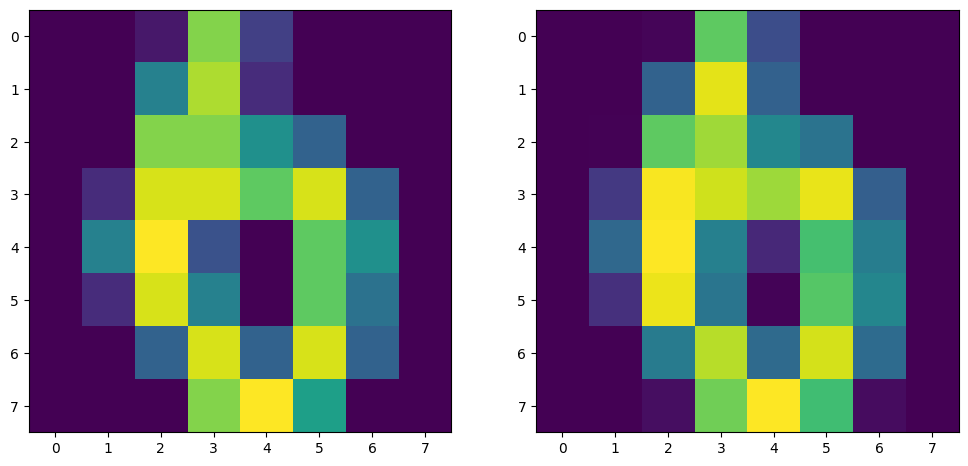

In [140]:
import matplotlib.pyplot as plt

idx = 0
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.imshow(images[idx].reshape(8, 8))
plt.subplot(1, 2, 2)
plt.imshow(batch_predictions[idx].reshape(8, 8))
plt.show()

# Plot tsne

some color settings

In [141]:
import matplotlib.colors as mcolors

def color_map(value):
    max_value = 10 # max_value here is number of classes.
    hue = value / max_value
    rgb = mcolors.hsv_to_rgb([hue, 1, 1])
    return rgb

def color_map_array(values):
    return [color_map(value) for value in values]

let start here

In [142]:
training_set = load_digits()
training_images, training_labels = training_set.data, training_set.target

with Bind(model, params, states) as ctx:
    images = jax.device_put(training_images.reshape(-1, 8, 8, 1))
    training_features = ctx.module.encoder(images)

In [143]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
training_features_2d = tsne.fit_transform(training_features.reshape(len(training_features), -1))

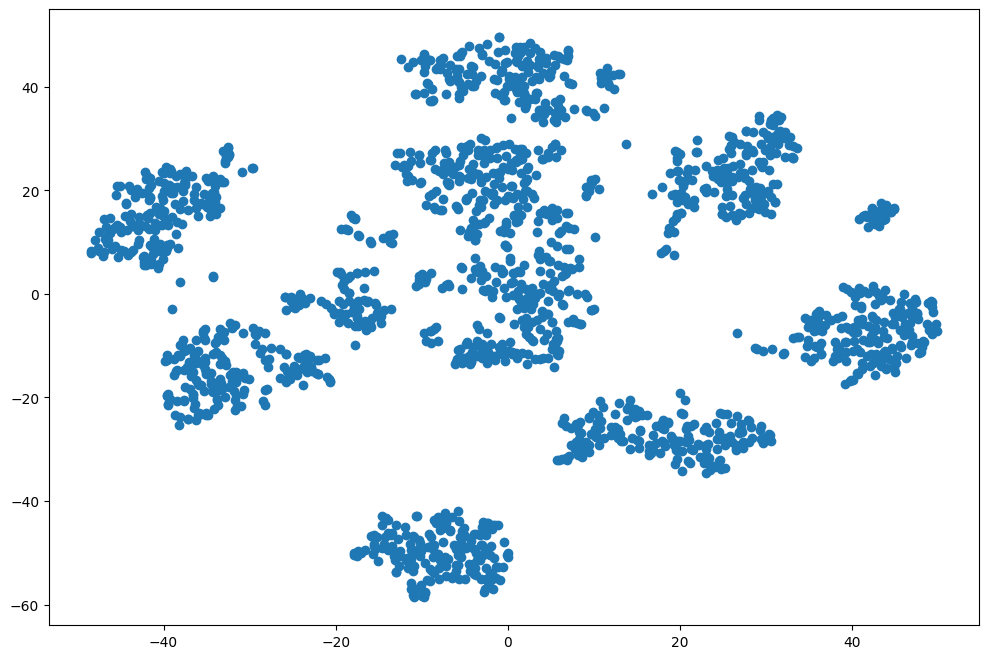

In [144]:
plt.figure(figsize=(12, 8))
plt.scatter(training_features_2d[..., 0], training_features_2d[..., 1])
plt.show()

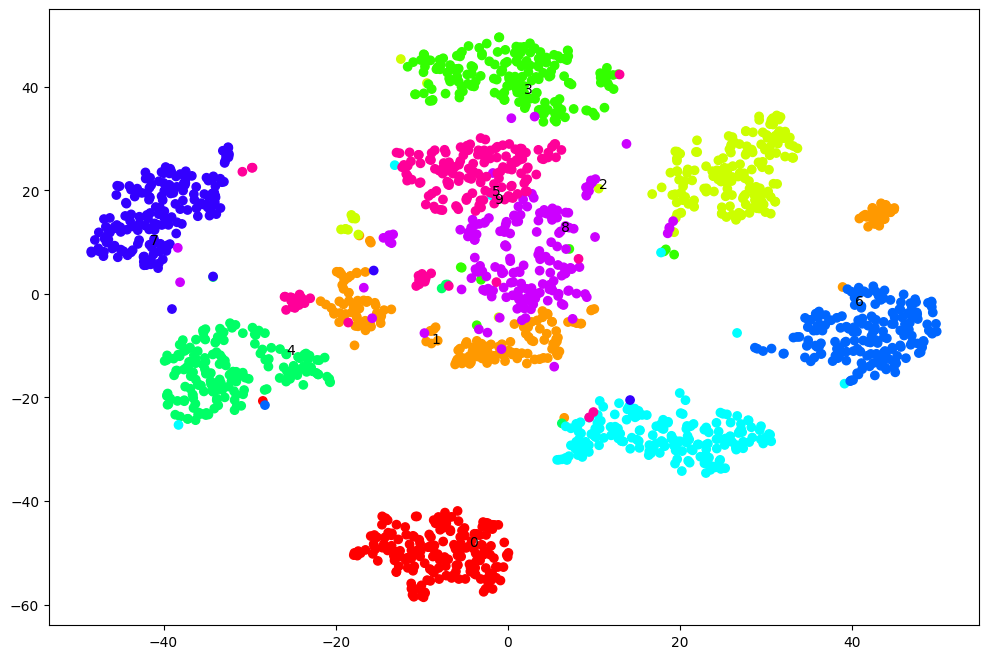

In [145]:
import numpy as np

unique_labels = np.unique(training_labels)
taken = []
plt.figure(figsize=(12, 8))
for label in unique_labels:
    idx = np.where(training_labels == label)
    plt.scatter(training_features_2d[idx, 0], training_features_2d[idx, 1], label=label, c=color_map_array(training_labels[idx]))
    if len(idx[0]) > 0:
        i = idx[0][0]
        if i not in taken:
            plt.annotate(str(label), (training_features_2d[i, 0], training_features_2d[i, 1]))
            taken.append(i)